# OLYMPUS_1 model
Model from the [ISAPP Optimization challenge](https://www.isapp2.com/optimization-challenge/reservoir-model-description.html)

In [1]:
using Jutul, JutulDarcy, GLMakie, DelimitedFiles, HYPRE
olympus_dir = JutulDarcy.GeoEnergyIO.test_input_file_path("OLYMPUS_1")
case = setup_case_from_data_file(joinpath(olympus_dir, "OLYMPUS_1.DATA"), backend = :csr)
ws, states = simulate_reservoir(case, output_substates = true)

     Failure artifact: OLYMPUS_1
Parser: GRID/PINCH - PINCH is only partially supported by JutulDarcy solvers.
Parser: GRID/COORDSYS - Unsupported keyword. It will be ignored.
Parser: PROPS/ROCKOPTS - ROCKOPTS is not supported by JutulDarcy solvers. It will be ignored in simulations.
Parser: SCHEDULE/GRUPTREE - Unsupported keyword. It will be ignored.
Transmissibility: Replaced 6357 negative half-transmissibilities (out of 1104454, 0.58%) with their absolute value.
Simulating 20 years, 3.6 hours as 20 report steps  10%|▎ |  ETA: 0:10:39
  Progress:  Solving step 2/20 (10.01% of time interval complete)


Simulating 20 years, 3.6 hours as 20 report steps  14%|▎ |  ETA: 0:11:05
  Progress:  Solving step 3/20 (15.00% of time interval complete)


Simulating 20 years, 3.6 hours as 20 report steps  19%|▍ |  ETA: 0:10:22
  Progress:  Solving step 4/20 (20.00% of time interval complete)


Simulating 20 years, 3.6 hours as 20 report steps  24%|▌ |  ETA: 0:08:44
  Progress:  Solving step 5/20 (25

ReservoirSimResult with 79 entries:

  wells (18 present):
    :INJ-7
    :PROD-4
    :INJ-5
    :INJ-4
    :PROD-9
    :INJ-2
    :PROD-3
    :PROD-2
    :PROD-8
    :INJ-3
    :PROD-6
    :PROD-1
    :PROD-10
    :PROD-7
    :PROD-5
    :INJ-6
    :PROD-11
    :INJ-1
    Results per well:
       :lrat => Vector{Float64} of size (79,)
       :wrat => Vector{Float64} of size (79,)
       :Aqueous_mass_rate => Vector{Float64} of size (79,)
       :orat => Vector{Float64} of size (79,)
       :control => Vector{Symbol} of size (79,)
       :bhp => Vector{Float64} of size (79,)
       :Liquid_mass_rate => Vector{Float64} of size (79,)
       :mass_rate => Vector{Float64} of size (79,)
       :rate => Vector{Float64} of size (79,)

  states (Vector with 79 entries, reservoir variables for each state)
    :Saturations => Matrix{Float64} of size (2, 192750)
    :Pressure => Vector{Float64} of size (192750,)
    :TotalMasses => Matrix{Float64} of size (2, 192750)

  time (report time for each

## Plot the reservoir

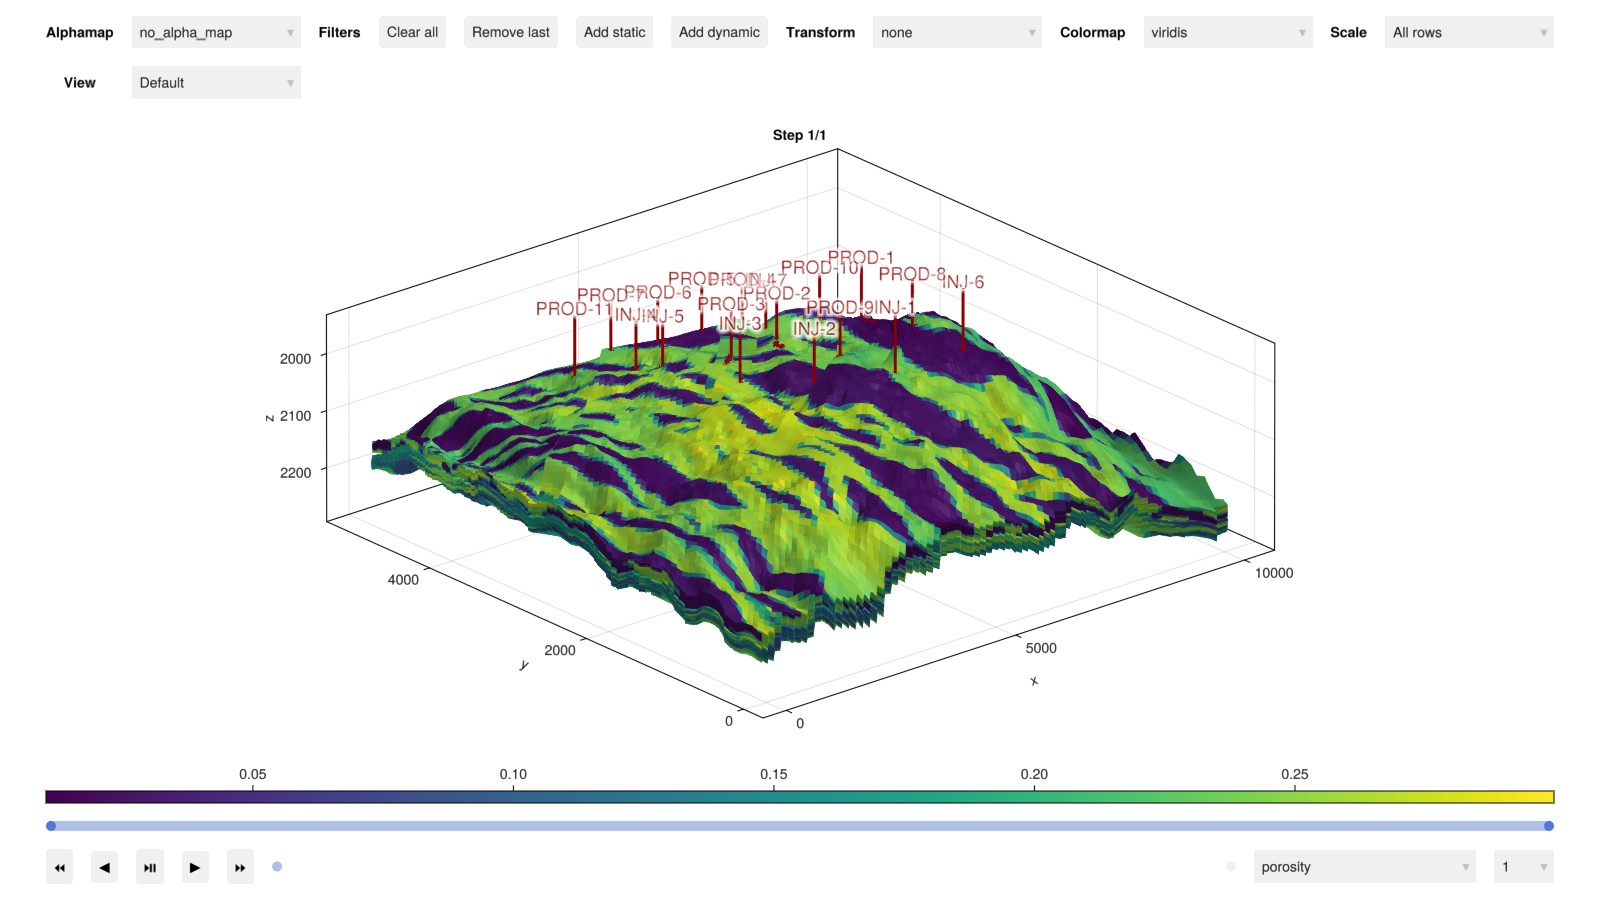

In [2]:
plot_reservoir(case.model, key = :porosity)

## Plot the saturations

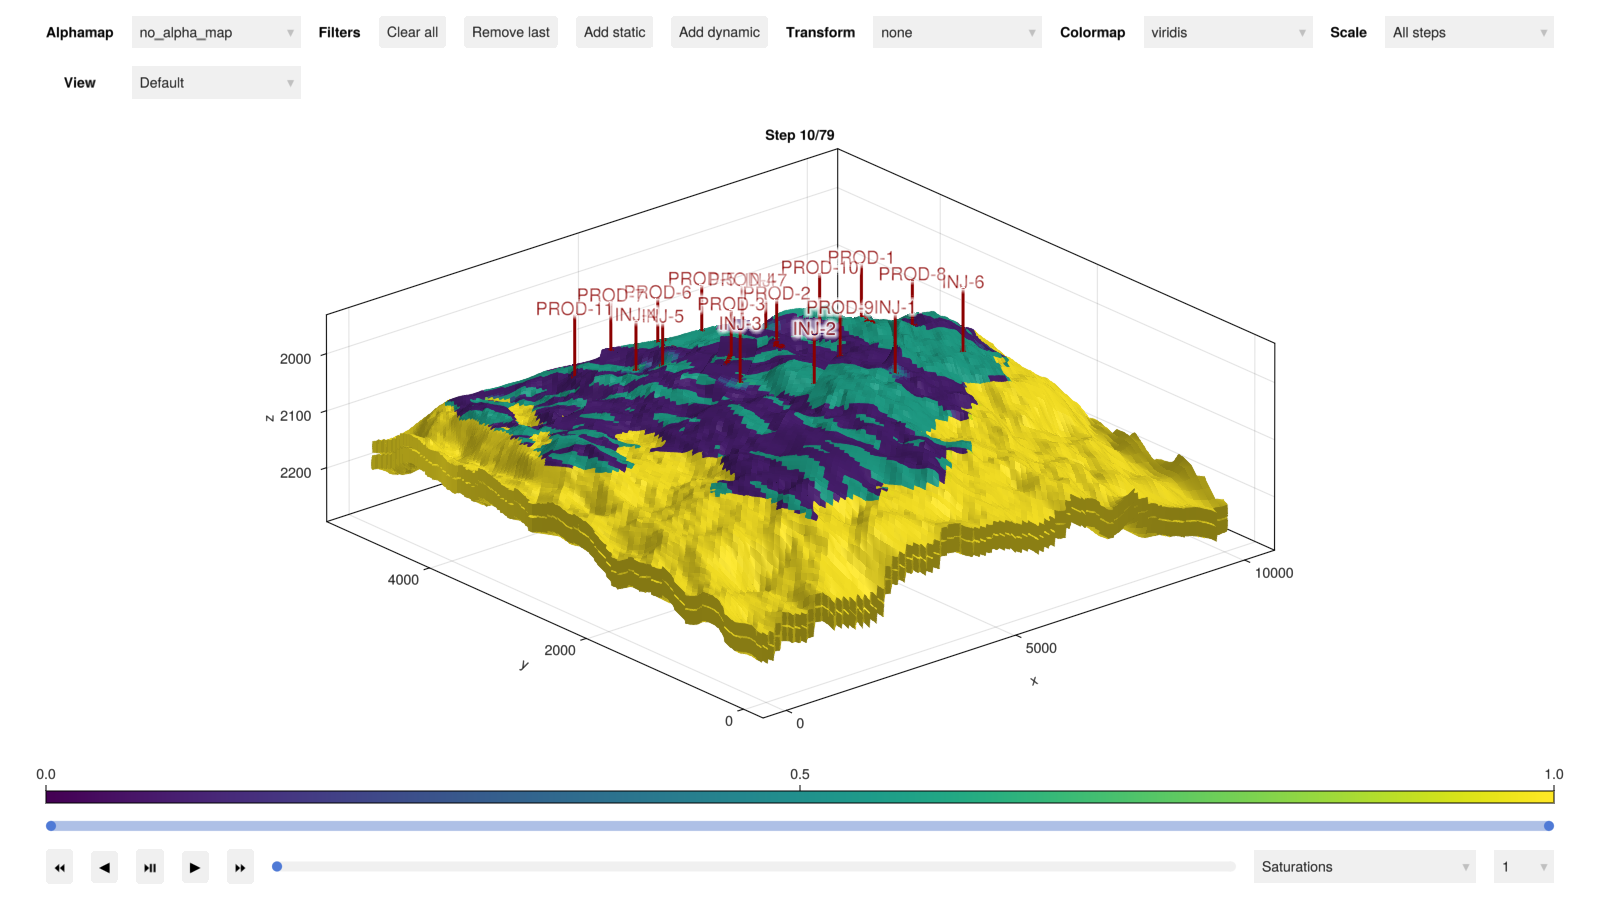

In [3]:
plot_reservoir(case.model, states, step = 10, key = :Saturations)

## Load reference and set up plotting

In [4]:
csv_path = joinpath(olympus_dir, "REFERENCE.CSV")
data, header = readdlm(csv_path, ',', header = true)
time_ref = data[:, 1]
time_jutul = deepcopy(ws.time)
wells = deepcopy(ws.wells)
wnames = collect(keys(wells))
nw = length(wnames)
day = si_unit(:day)
cmap = :tableau_hue_circle

inj = Symbol[]
prod = Symbol[]
for (wellname, well) in pairs(wells)
    qts = well[:wrat] + well[:orat]
    if sum(qts) > 0
        push!(inj, wellname)
    else
        push!(prod, wellname)
    end
end

function plot_well_comparison(response, well_names, reponse_name = "$response"; ylims = missing)
    fig = Figure(size = (1000, 400))
    if response == :bhp
        ys = 1/si_unit(:bar)
        yl = "Bottom hole pressure / Bar"
    elseif response == :wrat
        ys = si_unit(:day)
        yl = "Surface water rate / m³/day"
    elseif response == :orat
        ys = si_unit(:day)/(1000*si_unit(:stb))
        yl = "Surface oil rate / 10³ stb/day"
    else
        error("$response not ready.")
    end
    welltypes = []
    ax = Axis(fig[1:4, 1], xlabel = "Time / days", ylabel = yl)
    i = 1
    linehandles = []
    linelabels = []
    for well_name in well_names
        well = wells[well_name]
        label_in_csv = "$well_name:$response"
        ref_pos = findfirst(x -> x == label_in_csv, vec(header))
        qoi = copy(well[response]).*ys
        qoi_ref = data[:, ref_pos].*ys
        tot_rate = copy(well[:rate])
        @. qoi[tot_rate == 0] = NaN
        orat_ref = data[:, findfirst(x -> x == "$well_name:orat", vec(header))]
        wrat_ref = data[:, findfirst(x -> x == "$well_name:wrat", vec(header))]
        tot_rate_ref = orat_ref + wrat_ref
        @. qoi_ref[tot_rate_ref == 0] = NaN
        crange = (1, max(length(well_names), 2))
        lh = lines!(ax, time_jutul./day, abs.(qoi),
            color = i,
            colorrange = crange,
            label = "$well_name", colormap = cmap
        )
        push!(linehandles, lh)
        push!(linelabels, "$well_name")
        lines!(ax, time_ref./day, abs.(qoi_ref),
            color = i,
            colorrange = crange,
            linestyle = :dash,
            colormap = cmap
        )
        i += 1
        if !ismissing(ylims)
            ylims!(ax, ylims)
        end
    end
    l1 = LineElement(color = :black, linestyle = nothing)
    l2 = LineElement(color = :black, linestyle = :dash)

    Legend(fig[1:3, 2], linehandles, linelabels, nbanks = 3)
    Legend(fig[4, 2], [l1, l2], ["JutulDarcy.jl", "OPM Flow"])
    fig
end

plot_well_comparison (generic function with 2 methods)

## Plot water production rates

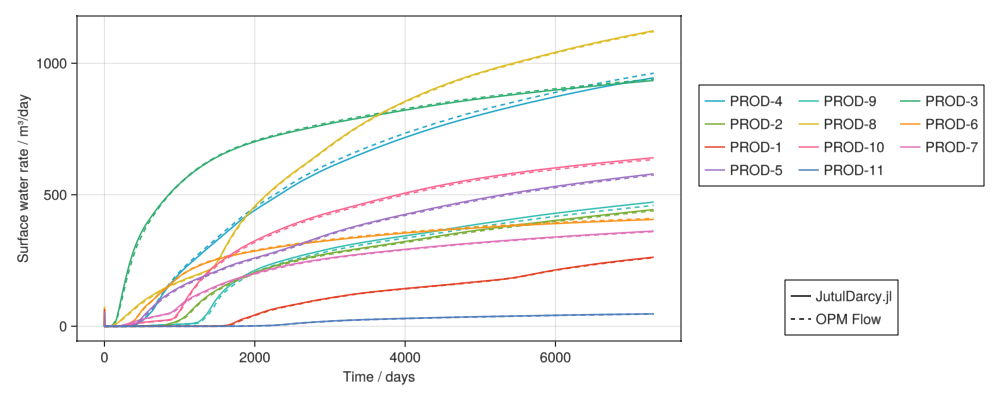

In [5]:
plot_well_comparison(:wrat, prod, "Water surface production rate")

## Plot oil production rates

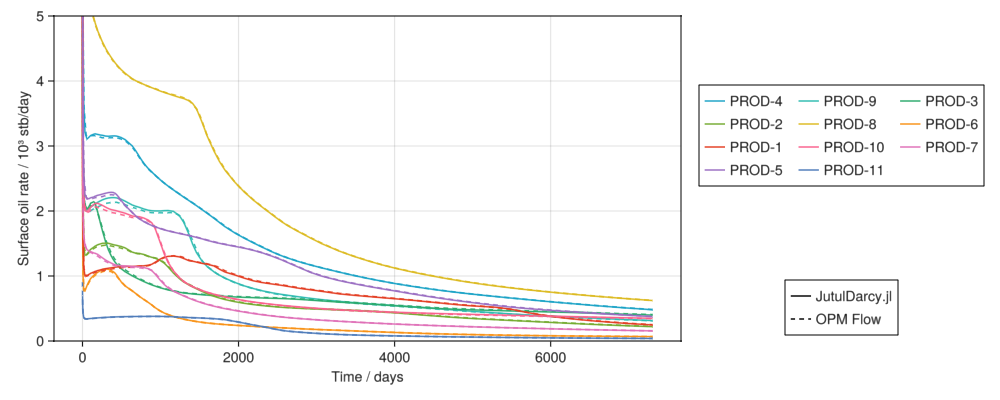

In [6]:
plot_well_comparison(:orat, prod, "Oil surface production rate", ylims = (0, 5))

## Plot water injection rates

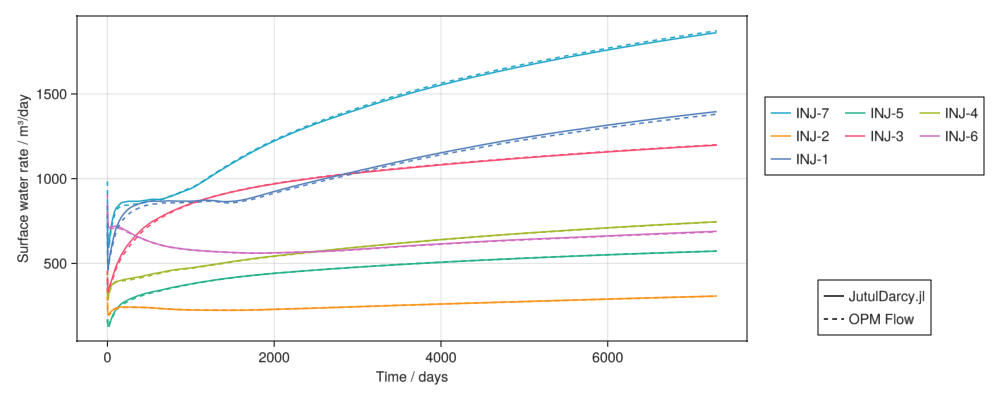

In [7]:
plot_well_comparison(:wrat, inj, "Water injection rate")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*